In [56]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage

In [57]:
df = pd.read_csv('featurized_condensed.csv')

In [58]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 10', 'Ingredients'])

In [59]:
df = df.set_index('ID')

In [60]:
cuisines = list(set(df['Cuisine']))

In [61]:
binary_cuisines = {}
counter = 0
for i in cuisines:
    length = np.zeros(len(cuisines))
    length[counter] = 1
    length = length.tolist()
    counter += 1
    binary_cuisines[i] = length

In [62]:
lists = {}
for i in df.iterrows():
    i[1][0] = binary_cuisines[i[1][0]]
    lists[i[0]] = i[1][0]+i[1][1:].get_values().tolist()

In [63]:
ncuisines = len(df['Cuisine'].unique())
print(ncuisines)
print(df['Cuisine'].unique())
nattributes = len(df.columns[1:7])
print(nattributes)
print(np.array(df.columns[1:7]))
ningredients = len(df.columns[7:])
print(ningredients)
print(df.columns[7:])

20
['thai' 'korean' 'japanese' 'cajun_creole' 'italian' 'indian' 'vietnamese'
 'jamaican' 'british' 'mexican' 'southern_us' 'chinese' 'greek' 'filipino'
 'moroccan' 'brazilian' 'irish' 'french' 'spanish' 'russian']
6
['Vegeterian (Y/N)' 'Vegan (Y/N)' 'Dessert (Y/N)' 'Spicy (Y/N)'
 'Drink (Y/N)' 'Alcohol (Y/N)']
395
Index(['paprika', 'quail eggs', 'sweet chili sauce', 'half & half',
       'allspice berries', 'carrots', 'peppercorns', 'cardamom',
       'vanilla ice cream', 'red chili',
       ...
       'paneer', 'cheese', 'onion powder', 'cauliflower', 'lemon juice',
       'vinegar', 'tumeric', 'back bacon rashers', 'plum tomatoes', 'beets'],
      dtype='object', length=395)


In [98]:
cuisine_names = np.array(df['Cuisine'].unique()).reshape(-1, 1)
descriptor_names = np.array(df.columns[1:7]).reshape(-1, 1)

item_names = np.append(cuisine_names, descriptor_names).reshape(-1, 1)

In [64]:
binary_df = pd.DataFrame(lists)
input_pats = binary_df.iloc[:,:ncuisines+nattributes]
input_pats = torch.tensor(np.array(input_pats),dtype=torch.float)
output_pats = binary_df.iloc[:,ncuisines+nattributes:]
output_pats = torch.tensor(np.array(output_pats),dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')

In [65]:
output_shape = output_pats.shape[1]

In [66]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        # TODO : YOUR CODE GOES HERE    
        
        self.i2r = nn.Linear(ncuisines+nattributes, rep_size)
        self.r2h = nn.Linear(rep_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_shape)
        #raise Exception('Replace with your code.')

    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,ncuisines+nattributes) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:ncuisines+nattributes] # input to Item Layer [B x nobj Tensor]
#         print("x item shape "+ str(x_item.shape))
        #x_rel = x[:,ncuisines:] # input to Relation Layer [B x nrel Tensor]
        # TODO : YOUR CODE GOES HERE
        
        rep = self.i2r(x_item)
        rep = relu(rep)
        #combined = torch.cat((rep, x_rel),1)
        hidden = self.r2h(rep)
        hidden = relu(hidden)
        output = self.h2o(hidden)
        output = sigmoid(output)
        #raise Exception('Replace with your code.')

        return output, hidden, rep

In [67]:
def train(mynet,epoch_count,nepochs_additional=5000):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
    for e in range(nepochs_additional): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(N)
        for p in perm: # iterate through input patterns in random order
            mynet.zero_grad() # reset gradient
            output, hidden, rep = mynet(input_pats[p,:]) # forward pass
            target = output_pats[p,:] 
    
            loss = criterion(output, target) # compute loss
            
            loss.backward() # compute gradient 
            optimizer.step() # update network parameters
            error_epoch += loss.item()
        error_epoch = error_epoch / float(N)        
        if e % 50 == 0:
            print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
    return epoch_count + nepochs_additional

In [140]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(26,26)
    for idx,name in enumerate(item_names):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean)
    return rep.detach().numpy()

def plot_rep(rep1, rep2, rep3, names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]

    nrows = 26
    R = np.dstack((rep1, rep2, rep3))    
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    count = 1
    plt.figure(1,figsize=(4.2,8.4))
    for i in range(nrows):
        for d in range(R.shape[2]):
            plt.subplot(nrows, depth, count)
            rep = R[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names[i])
            if i==0:
                plt.title("epoch " + str(nepochs_list[d]))
            count += 1
    plt.show()

def plot_dendo(rep1, rep2, rep3, names, x_rotation = 0):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2], linked2[:,2], linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(20, 40))
#     plt.subplot(3,1,1)    
#     dendrogram(linked1, labels = names, color_threshold = 0)
#     plt.ylim([0,mx])
#     plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
#     plt.ylabel('Euclidean distance')
#     plt.subplot(3,1,2)
#     plt.title("epoch " + str(nepochs_list[1]))
#     dendrogram(linked2, labels=names, color_threshold=0)
#     plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels = names, color_threshold = 0)
    plt.xticks(rotation = x_rotation)
    plt.show()

In [69]:
learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = Net(rep_size=8,hidden_size=15)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

nepochs_phase1 = 500
nepochs_phase2 = 1000
nepochs_phase3 = 2500
epoch_count = 0
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase1)
# rep1 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase2-nepochs_phase1)
# rep2 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase3-nepochs_phase2)
# rep3 = get_rep(mynet)


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 loss 0.225
epoch 50 loss 0.027
epoch 100 loss 0.027
epoch 150 loss 0.027
epoch 200 loss 0.026
epoch 250 loss 0.026
epoch 300 loss 0.026
epoch 350 loss 0.026
epoch 400 loss 0.025
epoch 450 loss 0.025
epoch 500 loss 0.025
epoch 550 loss 0.024
epoch 600 loss 0.024
epoch 650 loss 0.024
epoch 700 loss 0.024
epoch 750 loss 0.024
epoch 800 loss 0.024
epoch 850 loss 0.023
epoch 900 loss 0.023
epoch 950 loss 0.023
epoch 1000 loss 0.023
epoch 1050 loss 0.022
epoch 1100 loss 0.022
epoch 1150 loss 0.022
epoch 1200 loss 0.022
epoch 1250 loss 0.022
epoch 1300 loss 0.022
epoch 1350 loss 0.021
epoch 1400 loss 0.021
epoch 1450 loss 0.021
epoch 1500 loss 0.021
epoch 1550 loss 0.021
epoch 1600 loss 0.021
epoch 1650 loss 0.021
epoch 1700 loss 0.021
epoch 1750 loss 0.021
epoch 1800 loss 0.021
epoch 1850 loss 0.02
epoch 1900 loss 0.02
epoch 1950 loss 0.02
epoch 2000 loss 0.02
epoch 2050 loss 0.02
epoch 2100 loss 0.02
epoch 2150 loss 0.02
epoch 2200 loss 0.02
epoch 2250 loss 0.02
epoch 2300 loss 0.02

In [101]:
rep1 = get_rep(mynet)
rep2 = get_rep(mynet)
rep3 = get_rep(mynet)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [128]:
rep1[:20].shape

(20, 8)

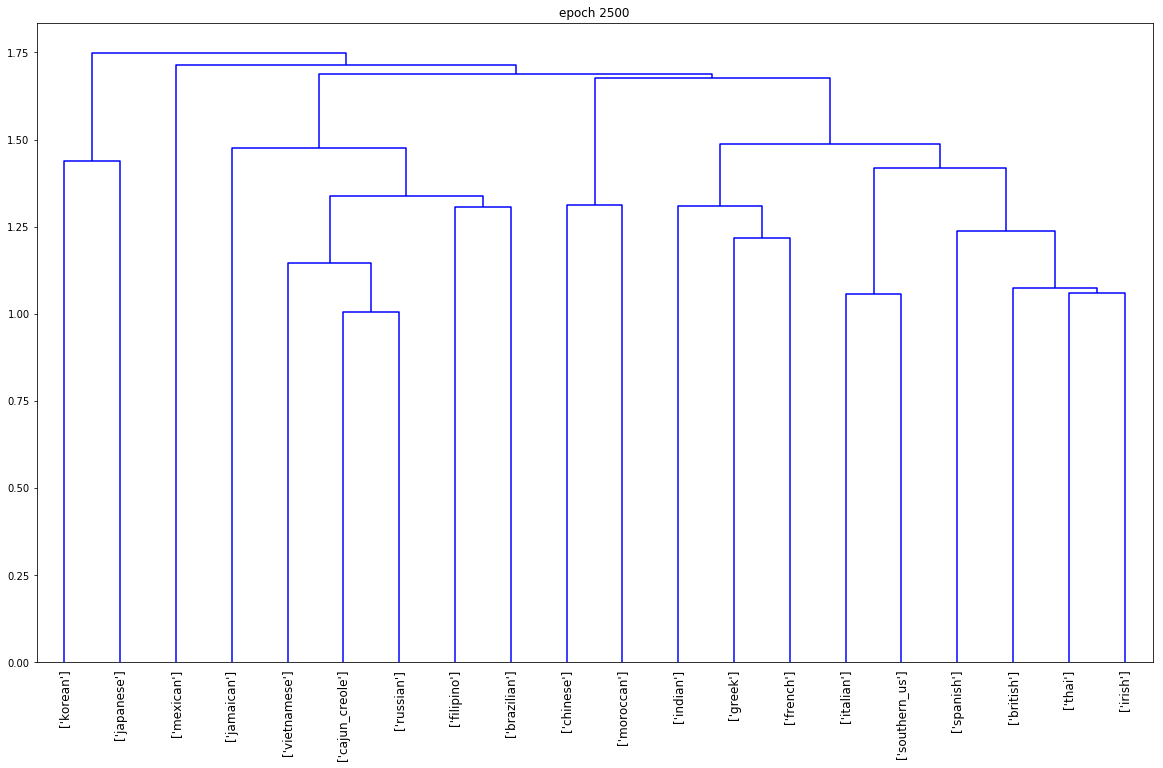

In [141]:
plot_dendo(rep1[:20], rep2[:20], rep3[:20], cuisine_names, x_rotation = 90)

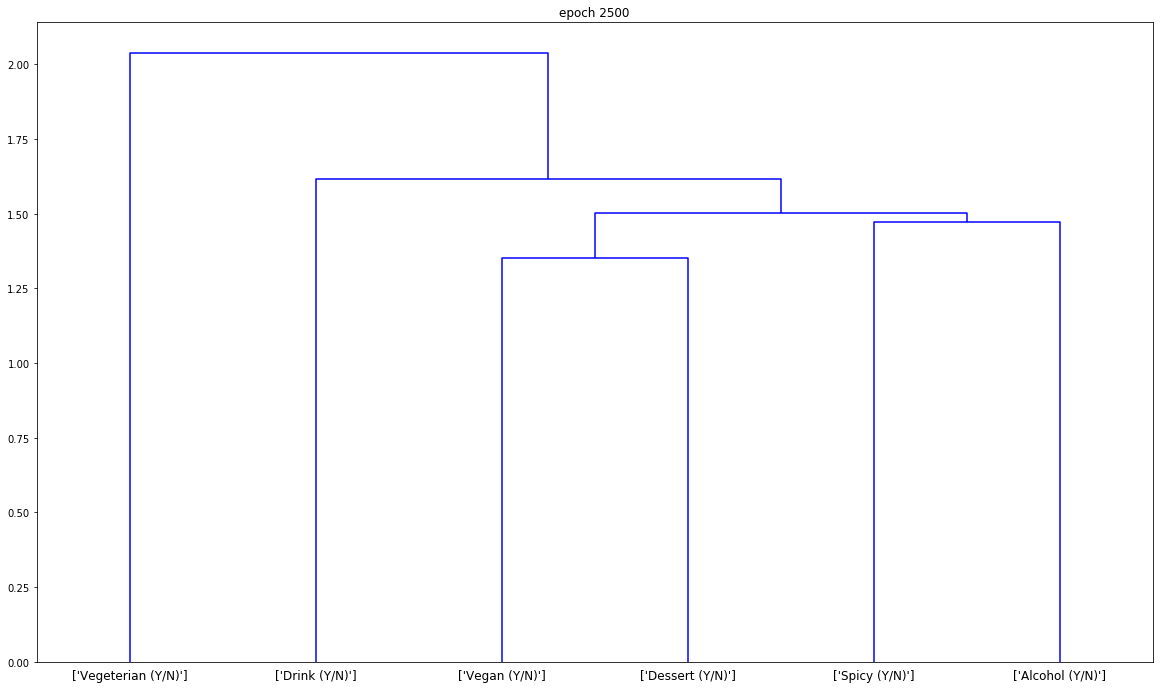

In [142]:
plot_dendo(rep1[20:], rep2[20:], rep3[20:], descriptor_names)

In [145]:
cuisine_names[5]

array(['indian'], dtype=object)

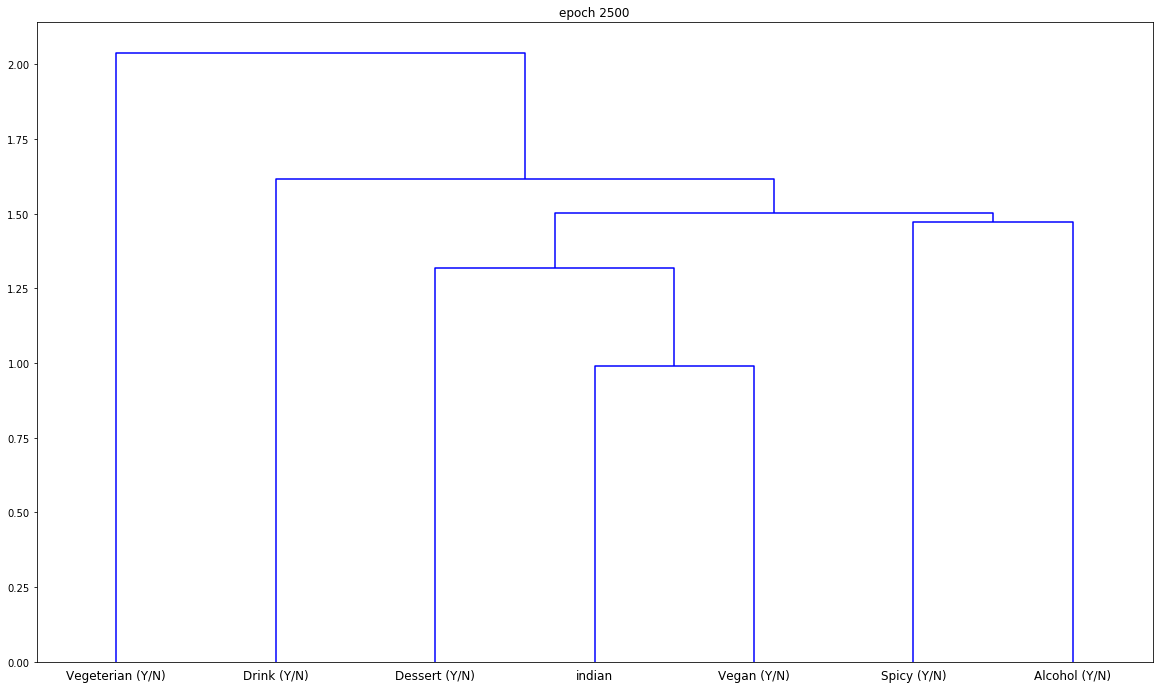

In [160]:
plot_dendo(rep1[[5, 20, 21, 22, 23, 24, 25], :], 
           rep2[[5, 20, 21, 22, 23, 24, 25], :], 
           rep3[[5, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[5], descriptor_names))



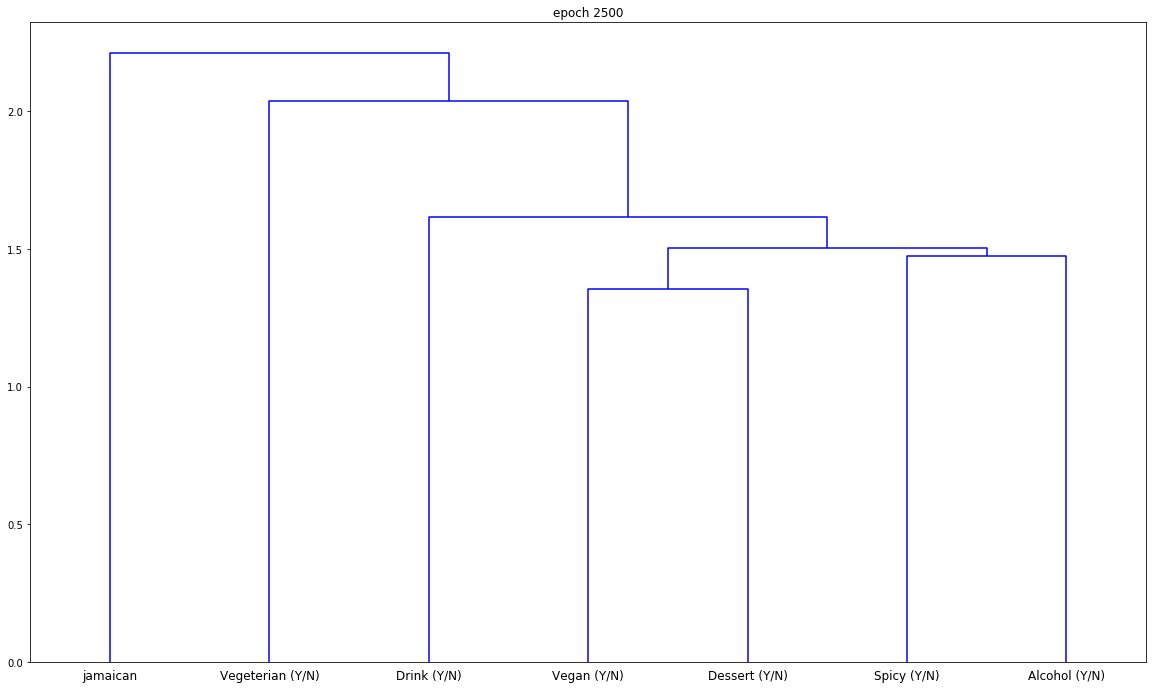

In [162]:
plot_dendo(rep1[[7, 20, 21, 22, 23, 24, 25], :], 
           rep2[[7, 20, 21, 22, 23, 24, 25], :], 
           rep3[[7, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[7], descriptor_names))

